In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import glob as glob
import os
%matplotlib inline

### Bulle Arclight Edge Data

In [2]:
Bulle_arclight_ON_Edge_data = pd.read_csv("data/Bulle/ArcLight_Edge_TimeSeries.txt",sep="\t")
column = ['time']
velocity = [15, 30, 60, 120, 240]
[column.extend(['Mean_PD_'+str(velocity[i]), 'SEM_PD_'+str(velocity[i]),
               'Mean_ND_'+str(velocity[i]), 'SEM_ND_'+str(velocity[i])]) for i in range(len(velocity))];
Bulle_arclight_ON_Edge_data.columns = column
#Bulle_arclight_ON_Edge_data

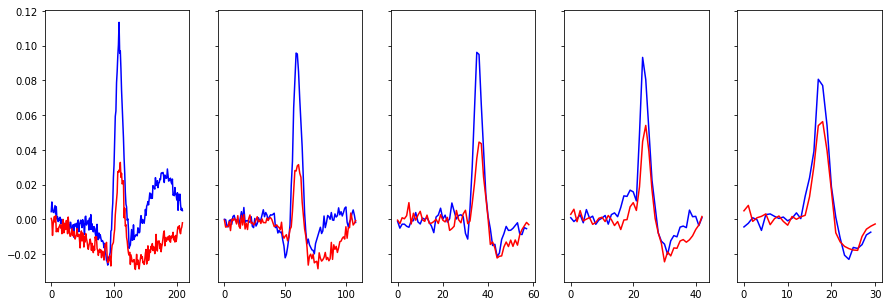

In [3]:
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(Bulle_arclight_ON_Edge_data['Mean_PD_'+str(velocity[i])],'b') for i in range(5)];
[ax[i].plot(Bulle_arclight_ON_Edge_data['Mean_ND_'+str(velocity[i])], 'r') for i in range(5)];
plt.savefig('figures/Bulle_ArcLight_ONEdge.pdf', dpi = 1000)

### Abhishek SPARC_GCaMP Edge Data

In [4]:
DATAPATH = os.path.join(os.getcwd(),'data/Abhishek/SPARC/ONEdge/')
df_list = os.listdir(DATAPATH)
#df_list
df_SPARC_Abhi_ONEdge = pd.read_pickle(DATAPATH + df_list[0])
for i in range(1, len(df_list)):
    df_SPARC_Abhi_ONEdge = df_SPARC_Abhi_ONEdge.join(pd.read_pickle(DATAPATH+df_list[i]))
df_SPARC_Abhi_ONEdge.index.name = 'time'
df_SPARC_Abhi_ONEdge = df_SPARC_Abhi_ONEdge.reset_index()
#df_ArcLight_Abhi_ONEdge

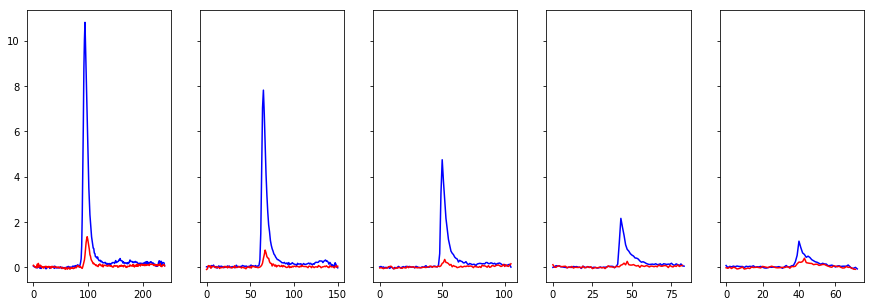

In [5]:
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(df_SPARC_Abhi_ONEdge['Mean_PD_'+str(velocity[i])], 'b') for i in range(5)];
[ax[i].plot(df_SPARC_Abhi_ONEdge['Mean_ND_'+str(velocity[i])], 'r') for i in range(5)];
plt.savefig('figures/Abhishek_SPARC_GCamp_ONEdge.pdf', dpi = 1000)

#### Model (threshold, lowpass filter, gain)

In [6]:
def lowpass_filter(x, tau=0.550,dt=0.01):
    y = np.zeros(len(x))
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,len(y)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
        
    return y

In [7]:
def threshold_cut(x, thres=0):
    x[x<thres] = 0
    return x

In [8]:
def Ca_model(x, tau=0.550, dt=0.0769, thres=0.0, gain=1.0):
    x_thres = threshold_cut(x, thres)
    x_thres_lowpass = lowpass_filter(x_thres, tau, dt)
    x_thres_lowpass_gain = gain*x_thres_lowpass
    
    return x_thres_lowpass_gain

In [28]:
def peak_error_calc(x, y):
    err = (np.nanmax(x) - np.nanmax(y))**2
    return err

In [10]:
velocity = [15, 30, 60, 120, 240]
df_arclight = Bulle_arclight_ON_Edge_data.copy()
thres = 0.0; tau = 0.3; gain = 120; dt = df_arclight.iloc[7]['time'] - df_arclight.iloc[6]['time']
# f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
# [ax[i].plot(df_arclight['Mean_PD_'+str(velocity[i])],'b') for i in range(5)];
# [ax[i].plot(df_arclight['Mean_ND_'+str(velocity[i])], 'r') for i in range(5)];

In [24]:
#velocities used for error calculation
velocity = [15, 30, 60,120,240]; stim=[]
[stim.extend(['Mean_PD_'+str(velocity[i]),'Mean_ND_'+str(velocity[i])]) for i in range(len(velocity))];
#[stim.extend(['Mean_PD_'+str(velocity[i])]) for i in range(len(velocity))];
print (stim)

['Mean_PD_15', 'Mean_ND_15', 'Mean_PD_30', 'Mean_ND_30', 'Mean_PD_60', 'Mean_ND_60', 'Mean_PD_120', 'Mean_ND_120', 'Mean_PD_240', 'Mean_ND_240']


In [29]:
thres = np.linspace(-0.04, 0.10, 20)
tau =np.linspace(0.05,1.5,20)
gain = np.linspace(50.0, 200.0, 20)
error = np.zeros((len(thres), len(tau), len(gain)))
for i in range(len(thres)):
    for j in range(len(tau)):
        for k in range(len(gain)):
            err_= 0
            for sti in stim:
                PD_Gcamp_data = np.array(df_SPARC_Abhi_ONEdge[sti])
                PD_arclight = np.array(df_arclight[sti])
                model_data = Ca_model(PD_arclight.copy(), tau[j], dt, thres[i], gain[k])
                err_ += peak_error_calc(PD_Gcamp_data.copy(), model_data.copy())
            error[i, j, k] = err_/len(stim)
error.min()

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


0.6600658181195979

In [26]:
thres_model = thres[np.argwhere(error == np.min(error))[0][0]]
tau_model = tau[np.argwhere(error == np.min(error))[0][1]]
gain_model = gain[np.argwhere(error == np.min(error))[0][2]]
thres_model, tau_model, gain_model 

(0.055789473684210535, 0.8131578947368422, 192.10526315789474)

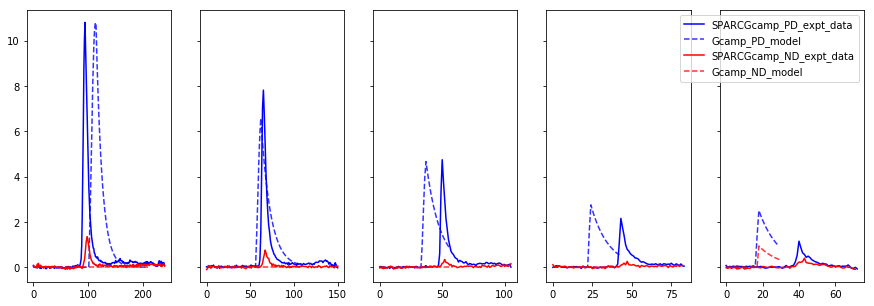

In [27]:
velocity = [15, 30, 60, 120, 240]
f, ax = plt.subplots(1,5, sharey=True, figsize=(15,5))
[ax[i].plot(df_SPARC_Abhi_ONEdge['Mean_PD_'+str(velocity[i])],'b',label='SPARCGcamp_PD_expt_data') for i in range(5)];
[ax[i].plot(Ca_model(df_arclight['Mean_PD_'+str(velocity[i])].copy(),
                    tau_model, dt, thres_model, gain_model), 'b--', label='Gcamp_PD_model', alpha=0.8) for i in range(5)];

[ax[i].plot(df_SPARC_Abhi_ONEdge['Mean_ND_'+str(velocity[i])],'r',label='SPARCGcamp_ND_expt_data') for i in range(5)];
[ax[i].plot(Ca_model(df_arclight['Mean_ND_'+str(velocity[i])].copy(),
                    tau_model, dt, thres_model, gain_model), 'r--', label='Gcamp_ND_model', alpha=0.8) for i in range(5)];
plt.legend();
plt.savefig('figures/SPARC_ONEdge_Model.pdf', dpi = 1000)